#0. Import Libraries

In [ ]:
!pip install yfinance

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import yfinance as yf

from pandas_datareader import data as pdr
pd.core.common.is_list_like = pd.api.types.is_list_like
yf.pdr_override()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#1. Get Data

### 1-1. get data from yahoo finance

In [9]:
SPY_df = pdr.get_data_yahoo('SPY','2012-01-01','2021-07-31') #(종목, 시작일, 종료일)

SPY_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,105.985199,193697900
2012-01-04,127.199997,127.809998,126.709999,127.699997,106.151421,127186500
2012-01-05,127.010002,128.229996,126.430000,128.039993,106.434067,173895000
2012-01-06,128.199997,128.220001,127.290001,127.709999,106.159752,148050000
2012-01-09,128.000000,128.179993,127.410004,128.020004,106.417435,99530200
...,...,...,...,...,...,...
2021-07-26,439.309998,441.029999,439.260010,441.019989,441.019989,43719200
2021-07-27,439.910004,439.940002,435.989990,439.010010,439.010010,67397100
2021-07-28,439.679993,440.299988,437.309998,438.829987,438.829987,52472400


In [10]:
SPY_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2410 entries, 2012-01-03 to 2021-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2410 non-null   float64
 1   High       2410 non-null   float64
 2   Low        2410 non-null   float64
 3   Close      2410 non-null   float64
 4   Adj Close  2410 non-null   float64
 5   Volume     2410 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 131.8 KB


In [11]:
SPY_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2.410000e+03
mean,237.817124,238.992481,236.535772,237.861900,221.121609,1.027442e+08
std,71.309388,71.693663,70.869372,71.314943,77.991543,5.102136e+07
min,127.010002,127.809998,126.430000,127.500000,105.985199,2.027000e+07
25%,188.419998,189.160000,187.165001,188.122498,165.114388,6.599955e+07
50%,217.384995,218.209999,216.590004,217.514999,198.493622,9.071610e+07
75%,282.582504,284.157501,280.679993,282.757500,270.377373,1.266668e+08
max,439.910004,441.799988,439.809998,441.019989,441.019989,5.072443e+08


### 1-2. Feature & Target data

In [12]:
# Attribute 1: Open - Close
# Attribute 2: High - Low

In [13]:
# Copy본으로 진행
tmp_df = SPY_df.copy()

In [14]:
# Adj Close, Volume은 필요없으므로 인덱싱해서 빼줌
tmp_df = tmp_df[tmp_df.columns[:4]]

In [18]:
tmp_df['OC'] = tmp_df.Open - tmp_df.Close

tmp_df['HL'] = tmp_df.High - tmp_df.Low

tmp_df

,Open,High,Low,Close,OC,HL
Date,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,0.260002,0.950005
2012-01-04,127.199997,127.809998,126.709999,127.699997,-0.500000,1.099998
2012-01-05,127.010002,128.229996,126.430000,128.039993,-1.029991,1.799995
2012-01-06,128.199997,128.220001,127.290001,127.709999,0.489998,0.930000
2012-01-09,128.000000,128.179993,127.410004,128.020004,-0.020004,0.769989
...,...,...,...,...,...,...
2021-07-26,439.309998,441.029999,439.260010,441.019989,-1.709991,1.769989
2021-07-27,439.910004,439.940002,435.989990,439.010010,0.899994,3.950012
2021-07-28,439.679993,440.299988,437.309998,438.829987,0.850006,2.989990


In [19]:
X_val = tmp_df[['OC','HL']]

X_val

,OC,HL
Date,,
2012-01-03,0.260002,0.950005
2012-01-04,-0.500000,1.099998
2012-01-05,-1.029991,1.799995
2012-01-06,0.489998,0.930000
2012-01-09,-0.020004,0.769989
...,...,...
2021-07-26,-1.709991,1.769989
2021-07-27,0.899994,3.950012
2021-07-28,0.850006,2.989990


In [21]:
y_val = np.where(tmp_df.Close.shift(-1) > tmp_df.Open.shift(-1),1,-1) # (조건, 참일 경우의 값, 거짓일 경우의 값)

y_val

array([ 1,  1, -1, ...,  1,  1, -1])

### 1-3. Visualization Feature data

In [27]:
x_min, x_max = X_val.OC.min() - 0.5 , X_val.OC.max() + 0.5

y_min, y_max = X_val.HL.min() - 0.5 , X_val.HL.max() + 0.5

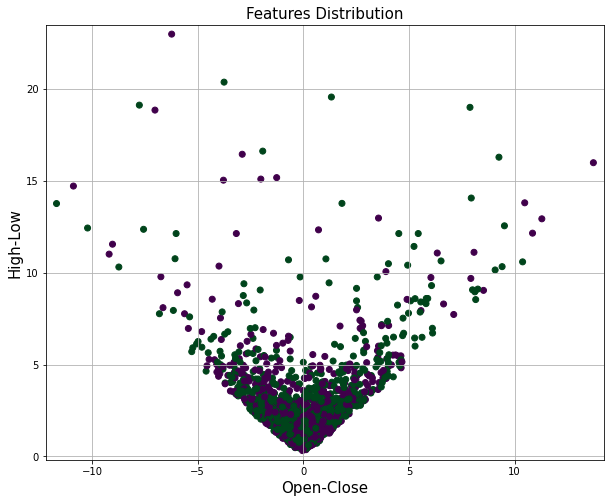

In [31]:
plt.figure(figsize=(10,8))

plt.scatter(X_val.OC, X_val.HL, c=y_val, cmap='PRGn')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title('Features Distribution', fontsize=15)
plt.xlabel('Open-Close', fontsize=15)
plt.ylabel('High-Low', fontsize=15)
plt.grid()

plt.show()

### 1-4. Standardization

### 1-4-1. 표준화 (Standardization) -> 평균=0, 표준편차=1

In [32]:
standardizer = StandardScaler()

In [33]:
X_val_standardized = standardizer.fit_transform(X_val)

X_val_standardized

array([[ 0.16381711, -0.66843675],
       [-0.24468142, -0.60189324],
       [-0.52954984, -0.29134559],
       ...,
       [ 0.48094221,  0.23658542],
       [-0.42204807, -0.20705602],
       [-0.29843436, -0.07395546]])

In [34]:
print(round(X_val_standardized.mean()))
print(round(X_val_standardized.std()))

0
1


### 1-4-2. 정규화 (Normalization) -> 0~1 (지금은 안할 거임)

#2. Split into Train & Test data

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X_val_standardized, y_val, test_size=0.3, random_state=42, shuffle=False)

#3. Train Model Object

### 3-1. Training


In [37]:
train_acc = []

test_acc = []

for n in tqdm(range(1,15)):

  clf = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
  clf.fit(x_train, y_train)

  pred = clf.predict(x_test)

  train_acc.append(clf.score(x_train, y_train))
  test_acc.append((pred==y_test).mean())

100%|██████████| 14/14 [00:04<00:00,  3.36it/s]


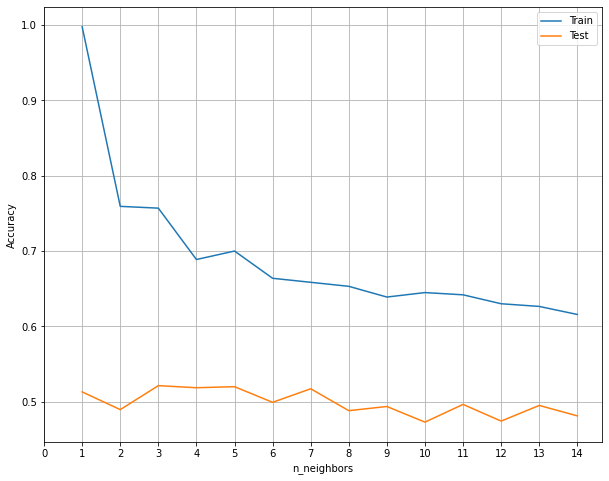

In [39]:
plt.figure(figsize=(10,8))

plt.plot(range(1,15), train_acc, label='Train')
plt.plot(range(1,15), test_acc, label='Test')

plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.xticks(range(0,15))
plt.legend()
plt.grid()
plt.show()

### 3-2. Model Performance

In [40]:
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=7)

clf.fit(x_train, y_train)

print(accuracy_score(y_test, clf.predict(x_test)))

0.5172890733056709
